# Trabalho Prático 1 - Introdução à Computação Visual

## Introdução

O objetivo deste trabalho é a implementação de um método de compressão de imagens em escala de cinza. Deverá ser possível comprimir uma imagem sem compressão passada como entrada, salvar essa imagem e, posteriormente, passar como entrada uma imagem comprimida pelo método aqui implementado e exibi-la. A compressão pode ser tanto com perda quanto sem perda. O PSNR deverá ser exibido após a compressão da imagem.

## Implementação

O método implementado neste trabalho consiste na implementação da codificação preditiva sem perdas com o processo da codificação de Huffman no final. Para uma dada imagem inserida, o compressor irá salvar somente o primeiro pixel da imagem, presente na origem (0, 0). A partir daí, uma função de predição irá tentar retornar o valor do próximo pixel. A diferença entre o valor predito e o valor real será o erro obtido. Esse erro será o valor salvo para codificação naquele ponto, de forma a reduzir a entropia da imagem, obtendo, no final, uma matriz com uma frequência alta de poucos valores. Os valores dessa matriz serão, ao final, codificados em uma árvore com a codificação de Huffman, diminuindo o número médio de bits por pixel.

Para obter a imagem novamente, será necessário somente realizar um processo para reverter a codificação de Huffman e, a partir do primeiro pixel, gerar os pixels seguintes, de acordo com a diferença obtida entre a função inversa de predição e o valor real, que estará na matriz.

Para podermos testar o impacto de cada um dos dois métodos utilizados na taxa de compressão, o algoritmo será modularizado e parametrizado de forma que possa ser utilizado livremente qualquer um dos dois métodos a qualquer momento, além de poder utilizar os dois em conjunto. É importante notar que há também a presença de um algoritmo binário comum, que codifica os pixels utilizando o número de bits mínimo necessário para representar todos os pixels únicos presentes na imagem. Caso seja possível representar todos os pixels com menos de 8 bits, o algoritmo conseguirá comprimir a imagem, mesmo sem utilizar a codificação de Huffman ou a codificação preditiva, como é visto no último exemplo.

### Importações

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import heapq
import base64

### Definições de variáveis constantes

In [2]:
INPUT_UNCOMPRESSED_IMG_PATH = "lena512.pgm"
COMPRESSED_IMG_PATH = "lena512.mycompress"

# Alterar essas variáveis irá ativar ou desativar esses métodos de compressão.
USE_PREDICTION = True
USE_HUFFMAN = True

### Implementação da codificação preditiva e sua decodificação

In [3]:
def predictionFunction(x, raveledImg):
    return raveledImg[x - 1] - 256

def predictiveCode(img):
    imgShape = img.shape
    raveledImg = img.ravel()
    firstElement = raveledImg[0]
    errorMatrix = np.empty(raveledImg.shape, dtype=int)
    # O primeiro elemento será exatamente o primeiro valor.
    errorMatrix[0] = raveledImg[0]
    for x, currentValue in enumerate(raveledImg[1:], 1):
        predictedValue = predictionFunction(x, raveledImg)
        error = int(currentValue) - int(predictedValue)
        errorMatrix[x] = error
    errorMatrix = errorMatrix.reshape(imgShape)
    return errorMatrix
    
def predictiveDecode(errorMatrix):
    imgShape = errorMatrix.shape
    errorMatrix = errorMatrix.ravel()
    img = np.empty(errorMatrix.shape, dtype=int)
    # Como a função de predição utiliza o elemento anterior, ao menos o primeiro elemento deve estar preenchido.
    img[0] = errorMatrix[0]
    for x, error in enumerate(errorMatrix[1:], 1):
        predictedValue = predictionFunction(x, img)
        img[x] = predictedValue + error
    img = img.reshape(imgShape)
    return img

### Implementação da codificação de Huffman e sua decodificação

In [4]:
class Node:
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    # Sobrescreve operadores de comparação que são usados na fila de prioridade.
    # Como essa comparação só é feita quando a frequência é igual para dois valores, a ordem não fará diferença.
    def __lt__(self, other):
        return True

    def __gt__(self, other):
        return True

def generatePriorityQueue(img):
    values, frequencies = np.unique(img, return_counts=True)
    priorityQueue = np.asarray((frequencies, values)).T.tolist()
    heapq.heapify(priorityQueue)
    return priorityQueue

def generateBinaryTree(priorityQueue):
    for _ in range(len(priorityQueue) - 1):
        lowerElement = heapq.heappop(priorityQueue)
        secondLowerElement = heapq.heappop(priorityQueue)
        # O primeiro valor da tupla é a frequência e o segundo é o valor em si.
        newFrequency = lowerElement[0] + secondLowerElement[0]
        node = Node(lowerElement[1], secondLowerElement[1])
        heapq.heappush(priorityQueue, [newFrequency, node])
    return heapq.heappop(priorityQueue)[1]

def recursiveDFS(currentNode, code, currentValue):
    currentValue = currentValue + '0'
    if isinstance(currentNode.left, Node):
        recursiveDFS(currentNode.left, code, currentValue)
    else:
        code[currentNode.left] = currentValue
        
    currentValue = currentValue[:-1] + '1'
    if isinstance(currentNode.right, Node):
        recursiveDFS(currentNode.right, code, currentValue)
    else:
        code[currentNode.right] = currentValue

def generateCode(binaryTree):
    initialValue = ''
    code = {}
    recursiveDFS(binaryTree, code, initialValue)
    return code
        
def huffmanCode(img):
    priorityQueue = generatePriorityQueue(img)
    binaryTree = generateBinaryTree(priorityQueue)
    code = generateCode(binaryTree)
    return code

def decodeHuffmanCode(headerData, body):
    reverseCode = dict((value, key) for key, value in headerData['code'].items())
    img = np.empty((headerData['xDimension'], headerData['yDimension']), dtype=int)
    currentIndex = 0
    for i in range(0, headerData['xDimension']):
        for j in range(0, headerData['yDimension']):
            currentCode = body[currentIndex:currentIndex+1]
            currentCodeSize = 1
            while currentCode not in reverseCode:
                currentCode = body[currentIndex:currentIndex+currentCodeSize+1]
                currentCodeSize += 1
            currentIndex += currentCodeSize
            img[i][j] = reverseCode[currentCode]
    return img

### Implementação da codificação binária tradicional

In [5]:
def intToBinary(number, length=0):
    return bin(number)[2:].zfill(length)

def binaryCode(img):
    code = {}
    uniqueValues = np.unique(img)
    minimumBitsLength = len(uniqueValues).bit_length()
    for i, value in enumerate(uniqueValues):
        code[value] = intToBinary(i, minimumBitsLength)
    return code

def decodeBinaryCode(headerData, body):
    valueSize = len(list(headerData['code'].values())[0])
    reverseCode = dict((value, key) for key, value in headerData['code'].items())
    img = np.empty((headerData['xDimension'], headerData['yDimension']), dtype=int)
    for i in range(0, headerData['xDimension']):
        for j in range(0, headerData['yDimension']):
            currentIndex = (i * headerData['yDimension'] + j) * valueSize
            currentValue = body[currentIndex:currentIndex+valueSize]
            img[i][j] = reverseCode[currentValue]
    return img

### Definição das funções de escrita e leitura de imagens comprimidas

In [6]:
def encodeHeader(img, code):
    header = '1' if USE_PREDICTION else '0'
    header += '1' if USE_HUFFMAN else '0'
    # Armazena as dimensões da imagem usando 2 bytes
    header += intToBinary(len(img), 16)
    header += intToBinary(len(img[0]), 16)
    # O intervalo de valores possíveis é [0, 511].
    # Esses valores podem ser representados usando, no máximo, 9 bits
    header += intToBinary(len(code), 9)
    maxBitsForValueLength = int(np.ceil(np.log2(max(len(value) for value in code.values())))) + 1
    header += intToBinary(maxBitsForValueLength, 8)
    for key, value in code.items():
        # O intervalo de valores possíveis é [0, 511].
        # Esses valores podem ser representados usando, no máximo, 9 bits
        header += intToBinary(key, 9)
        header += intToBinary(len(value), maxBitsForValueLength)
        header += value
    return header

def decodeHeader(encodedBinaryFile):
    header = {}
    header['usesPrediction'] = bool(int(encodedBinaryFile[0]))
    header['usesHuffman'] = bool(int(encodedBinaryFile[1]))
    header['xDimension'] = int(encodedBinaryFile[2:18], 2)
    header['yDimension'] = int(encodedBinaryFile[18:34], 2)
    header['codeSize'] = int(encodedBinaryFile[34:43], 2)
    header['maxBitsForValueLength'] = int(encodedBinaryFile[43:51], 2)
    header['code'] = {}
    valueIndex = 9 + header['maxBitsForValueLength']
    encodedBinaryFile = encodedBinaryFile[51:]
    for _ in range(0, header['codeSize']):
        key = int(encodedBinaryFile[0:9], 2)
        valueSize = int(encodedBinaryFile[9:valueIndex], 2)
        value = encodedBinaryFile[valueIndex:valueIndex+valueSize]
        encodedBinaryFile = encodedBinaryFile[valueIndex+valueSize:]
        header['code'][key] = value
    return header, encodedBinaryFile

def decodeBinaryString(encodedBinaryString):
    headerData, body = decodeHeader(encodedBinaryString)
    img = decodeHuffmanCode(headerData, body) if headerData['usesHuffman'] else decodeBinaryCode(headerData, body)
    if (headerData['usesPrediction']):
        img = predictiveDecode(img)
    return img

def encodeBody(img, code):
    body = ''
    for line in img:
        for cell in line:
            body += code[cell]
    return body

def encodeIntToBytes(number):
    return b''.join(int(number[i:i+8], 2).to_bytes(1, byteorder='big') for i in range(0, len(number), 8))

def decodeBytesToBinaryString(byteString):
    return ''.join(intToBinary(byte, 8) for byte in byteString)

def generateCompressedImageByteArray(header, body):
    compressedImage = header + body
    lengthDifferenceToEight = len(compressedImage) % 8
    if lengthDifferenceToEight != 0:
        compressedImage += intToBinary(0, 8 - lengthDifferenceToEight)
    compressedImage = encodeIntToBytes(compressedImage)
    return compressedImage

def writeCompressedImage(compressedImg):
    with open(COMPRESSED_IMG_PATH, 'wb') as file:
        file.write(compressedImg)

def readCompressedImage():
    with open(COMPRESSED_IMG_PATH, 'rb') as file:
        compressedImg = file.read()
    return compressedImg

### Definição das funções gerais

In [7]:
def showImage(img, title="Image"):
    plt.title(title)
    plt.imshow(img, cmap = 'gray')
    plt.show()
    
def readImage():
    return cv2.imread(INPUT_UNCOMPRESSED_IMG_PATH, cv2.IMREAD_GRAYSCALE)

def encodeImage(img):
    if USE_PREDICTION:
        img = predictiveCode(img)
    if USE_HUFFMAN:
        code = huffmanCode(img)
    else:
        code = binaryCode(img)
    return img, code

def compressImage(encodedImg, code):
    header = encodeHeader(encodedImg, code)
    body = encodeBody(encodedImg, code)
    compressedImg = generateCompressedImageByteArray(header, body)
    return compressedImg

def uncompressImage(compressedImg):
    encodedBinaryString = decodeBytesToBinaryString(compressedImg)
    img = decodeBinaryString(encodedBinaryString)
    return img

def calculateRMSE(originalImg, uncompressedImg):
    return np.sqrt(((originalImg - uncompressedImg) ** 2).mean())

def calculatePSNR(originalImg, uncompressedImg):
    rmse = calculateRMSE(originalImg, uncompressedImg)
    return np.inf if rmse == 0 else 20 * np.log10(255 / rmse)

def calculateCompression(originalSize, compressedSize):
    return originalSize / compressedSize

### Sandbox para uso das funções

In [8]:
def runAlgorithm():
    originalImg = readImage()
    encodedImg, code = encodeImage(originalImg)
    compressedImg = compressImage(encodedImg, code)
    writeCompressedImage(compressedImg)

    compressedImgRead = readCompressedImage()
    uncompressedImg = uncompressImage(compressedImgRead)

    showImage(originalImg, "Original Image")
    showImage(uncompressedImg, "Uncompressed Image")

    print ("RMSE: %5.3f" % calculateRMSE(originalImg, uncompressedImg))
    print ("PSNR: %5.3f" % calculatePSNR(originalImg, uncompressedImg))
    print ("Compression: %5.3f" % calculateCompression(originalImg.nbytes, len(compressedImg)))

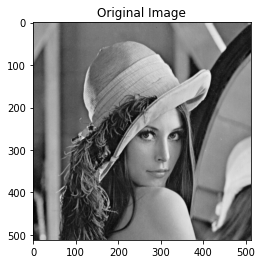

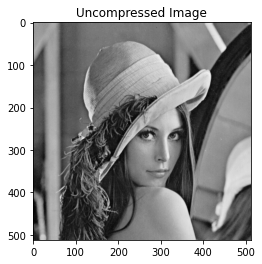

RMSE: 0.000
PSNR:   inf
Compression: 1.559


In [9]:
USE_PREDICTION = True
USE_HUFFMAN = True
INPUT_UNCOMPRESSED_IMG_PATH = "lena512.pgm"
COMPRESSED_IMG_PATH = "lena512.mycompress"

runAlgorithm()

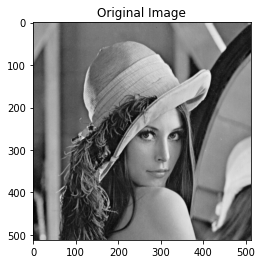

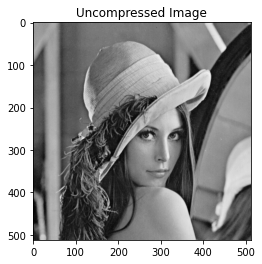

RMSE: 0.000
PSNR:   inf
Compression: 0.886


In [10]:
USE_PREDICTION = True
USE_HUFFMAN = False
INPUT_UNCOMPRESSED_IMG_PATH = "lena512.pgm"
COMPRESSED_IMG_PATH = "lena512.mycompress"

runAlgorithm()

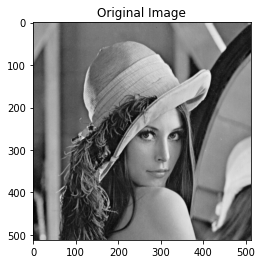

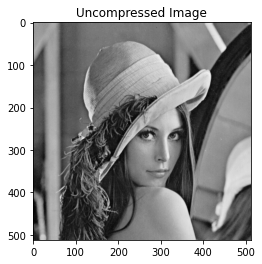

RMSE: 0.000
PSNR:   inf
Compression: 1.068


In [11]:
USE_PREDICTION = False
USE_HUFFMAN = True
INPUT_UNCOMPRESSED_IMG_PATH = "lena512.pgm"
COMPRESSED_IMG_PATH = "lena512.mycompress"

runAlgorithm()

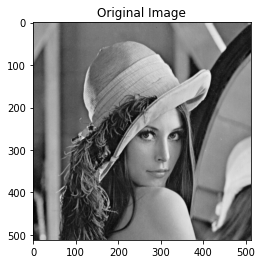

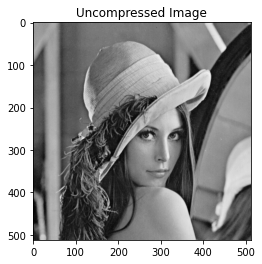

RMSE: 0.000
PSNR:   inf
Compression: 0.998


In [12]:
# Uma vez que a imagem manteve sua quantidade original de bytes por pixel e nenhum método de compressão foi utilizado,
# a imagem manteve o seu tamanho original, sendo acrescido a ela somente o tamanho do cabeçalho.

USE_PREDICTION = False
USE_HUFFMAN = False
INPUT_UNCOMPRESSED_IMG_PATH = "lena512.pgm"
COMPRESSED_IMG_PATH = "lena512.mycompress"

runAlgorithm()

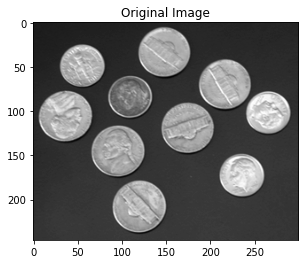

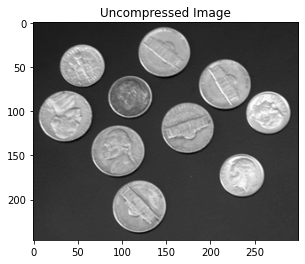

RMSE: 0.000
PSNR:   inf
Compression: 1.889


In [13]:
# Embora não use ambos os métodos implementados, a imagem poderá ficar menor
# que a original devido à codificação binária, que é utilizada quando não é
# utilizado o Huffman. Essa codificação pode diminuir a quantidade de bits por
# pixel se a imagem possuir poucos pixels de valores diferentes. Este caso
# ocorre na imagem coins.pgm, logo abaixo.
USE_PREDICTION = True
USE_HUFFMAN = True
INPUT_UNCOMPRESSED_IMG_PATH = "coins.pgm"
COMPRESSED_IMG_PATH = "coins.mycompress"

runAlgorithm()